<a href="https://colab.research.google.com/github/thamizhannal/eva5/blob/master/S10_assignement_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pwd


'/content'

In [2]:
!git clone https://github.com/theschoolof-ai/JEDI.git

Cloning into 'JEDI'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 289 (delta 14), reused 11 (delta 3), pack-reused 256
Receiving objects: 100% (289/289), 158.71 MiB | 38.14 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [3]:
cd /content/JEDI/tsai.jedi

/content/JEDI/tsai.jedi


In [4]:
ls

aftereffects.py  dataloader.py         gradcam.py      Models/
batchnorm.py     datatransforms.py     main.py         __pycache__/
config.py        Engine_train_test.py  model_objects/  README.md


In [5]:
import sys
sys.path.append('Models/')
from S8_resnet import ResNet18
from S7 import model_summary

In [6]:
import sys
sys.path.append('Models/')
from S7 import model_summary
from S9_resnet import resnet18

In [7]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 4.7MB/s 
     |████████████████████████████████| 952kB 14.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=5b1cfec3eaca2de00f4be397a48904d4a154c56ca5fcafaa8b97e306876dbdcc
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch.utils.data import Dataset


class train_transform_alb(Dataset):
    def __init__(self, image_list, label):
        self.image_list = image_list
        self.label = label
        self.aug = A.Compose([
            A.Cutout(num_holes=8,  max_h_size=8, max_w_size=8, p=0.5),
            A.RandomCrop(32, 32, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Rotate((-8.0, 8.0), p=0.5),
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, i):
        image = Image.fromarray(self.image_list[i]).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float)
        label = self.label[i]
        label = torch.tensor(label, dtype=torch.long)
        return image, label


class test_transform_alb(Dataset):
    def __init__(self, image_list, label):
        self.image_list = image_list
        self.label = label
        self.aug = A.Compose([
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, i):
        image = Image.fromarray(self.image_list[i]).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float)
        label = self.label[i]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [9]:
import sys
sys.path.append("tsai.jedi")
#from __future__ import print_function
import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from datatransforms import train_transform_alb, test_transform_alb
import config

torch.manual_seed(1)
kwargs = {'num_workers': config.num_workers, 'pin_memory': config.pin_memory} if config.use_cuda else {}

#MNIST
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=config.batch_size, shuffle=True, **kwargs)
test_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=config.batch_size, shuffle=True, **kwargs)
#CIFAR10
train_loader_CIFAR10 = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                     transform=transforms.Compose([
                         transforms.RandomCrop(32, padding=4),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomRotation((-8.0, 8.0)),
                         transforms.ToTensor(),
                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                     ])),
    batch_size=config.batch_size, shuffle=True, **kwargs)
test_loader_CIFAR10 = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])),
    batch_size=config.batch_size, shuffle=True, **kwargs)

#CIFAR-10 Albumentation
datasets.CIFAR10('../data', train=True, download=True)


def load_cifar10_data(filename):
    with open('../data/cifar-10-batches-py/' + filename, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data']
    labels = batch['labels']
    return features, labels


batch_1, labels_1 = load_cifar10_data('data_batch_1')
batch_2, labels_2 = load_cifar10_data('data_batch_2')
batch_3, labels_3 = load_cifar10_data('data_batch_3')
batch_4, labels_4 = load_cifar10_data('data_batch_4')
batch_5, labels_5 = load_cifar10_data('data_batch_5')

test, label_test = load_cifar10_data('test_batch')

X_train = np.concatenate([batch_1, batch_2, batch_3, batch_4, batch_5], 0)
Y_train = np.concatenate([labels_1, labels_2, labels_3, labels_4, labels_5], 0)


def return_photo(batch_file):
    assert batch_file.shape[1] == 3072
    dim = np.sqrt(1024).astype(int)
    r = batch_file[:, 0:1024].reshape(batch_file.shape[0], dim, dim, 1)
    g = batch_file[:, 1024:2048].reshape(batch_file.shape[0], dim, dim, 1)
    b = batch_file[:, 2048:3072].reshape(batch_file.shape[0], dim, dim, 1)
    photo = np.concatenate([r, g, b], -1)
    return photo


X_train = return_photo(X_train)
X_test = return_photo(test)
Y_test = np.array(label_test)

classes_CIFAR10 = ('plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = train_transform_alb(image_list=X_train, label=Y_train)
testset = test_transform_alb(image_list=X_test, label=Y_test)

train_loader_CIFAR10_alb = torch.utils.data.DataLoader(trainset,
                                                   batch_size=config.batch_size, shuffle=True, **kwargs)

test_loader_CIFAR10_alb = torch.utils.data.DataLoader(testset,
                                                  batch_size=config.batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [10]:
sys.path.append(".")
%matplotlib inline
import torch
import config
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from Engine_train_test import train, test
#from dataloader import train_loader_CIFAR10_alb, test_loader_CIFAR10_alb

In [11]:
model_ = resnet18(num_classes = 10,pretrained = False).to(config.device)
print(model_summary(model_, config.input_size_CIFAR10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch.utils.data import Dataset


class train_transform_alb(Dataset):
    def __init__(self, image_list, label):
        self.image_list = image_list
        self.label = label
        self.aug = A.Compose([
            A.RandomCrop(32, 32, p=0.5),
            A.Cutout(num_holes=8,  max_h_size=8, max_w_size=8, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Rotate((-8.0, 8.0), p=0.5),
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, i):
        image = Image.fromarray(self.image_list[i]).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float)
        label = self.label[i]
        label = torch.tensor(label, dtype=torch.long)
        return image, label


class test_transform_alb(Dataset):
    def __init__(self, image_list, label):
        self.image_list = image_list
        self.label = label
        self.aug = A.Compose([
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, i):
        image = Image.fromarray(self.image_list[i]).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float)
        label = self.label[i]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-02


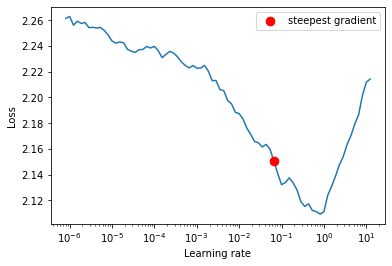

(<matplotlib.axes._subplots.AxesSubplot at 0x7f283e559518>,
 0.06579332246575686)

In [30]:
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")
'''
%matplotlib inline

import torch.nn as nn
import torch.optim as optim
from __future__ import print_function
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import sys



import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

accu = []
loss_test = []

# SGD
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=1e-7,  momentum=0.9, weight_decay=1e-2)
lr_finder = LRFinder(model_, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader_CIFAR10_alb, end_lr=100, num_iter=100, step_mode="exp")

lr_finder.plot()


In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
valid_acc = []
loss_test_ = []
l1_regularization = [0, 0]

# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau

# Assign optimizer with suggested learning rate and run it with reduceonpleatue
optimizer = optim.SGD(model_.parameters(), lr=5.34E-02,  momentum=0.9, weight_decay=1e-2) #  

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
for epoch in range(50):
    train(model_, config.device, train_loader_CIFAR10_alb, optimizer, epoch, l1_regularization=[0, 1])
    #scheduler.step()
    valid_a, valid_l = test(model_, config.device, test_loader_CIFAR10_alb)
    # Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    loss_test_.append(valid_l)
    # Note that step should be called after validate()
    scheduler.step(valid_l)

Epoch: 0,LR: 0.0534.
Train set: train Average loss: 1.2298, train_Accuracy: 22109/50000 (44.2180%)



loss=1.0989410877227783 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.79it/s]


Test set: Average loss: 0.0138, Accuracy: 3843/10000 (38.4300%)



Epoch: 1,LR: 0.0534.
Train set: train Average loss: 1.0300, train_Accuracy: 30390/50000 (60.7800%)



loss=1.2399870157241821 batch_id=0:   0%|          | 1/391 [00:00<01:13,  5.30it/s]


Test set: Average loss: 0.0125, Accuracy: 5122/10000 (51.2200%)



Epoch: 2,LR: 0.0534.
Train set: train Average loss: 1.0775, train_Accuracy: 32276/50000 (64.5520%)



loss=0.979661226272583 batch_id=0:   0%|          | 1/391 [00:00<01:11,  5.44it/s]


Test set: Average loss: 0.0125, Accuracy: 4895/10000 (48.9500%)



Epoch: 3,LR: 0.0534.
Train set: train Average loss: 1.0079, train_Accuracy: 32827/50000 (65.6540%)



loss=0.8037779927253723 batch_id=0:   0%|          | 1/391 [00:00<01:08,  5.69it/s]


Test set: Average loss: 0.0191, Accuracy: 3610/10000 (36.1000%)



Epoch: 4,LR: 0.0534.
Train set: train Average loss: 0.9621, train_Accuracy: 33005/50000 (66.0100%)



loss=0.9710895419120789 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.74it/s]


Test set: Average loss: 0.0111, Accuracy: 5147/10000 (51.4700%)



Epoch: 5,LR: 0.0534.
Train set: train Average loss: 1.1195, train_Accuracy: 33269/50000 (66.5380%)



loss=0.8582000136375427 batch_id=0:   0%|          | 1/391 [00:00<01:08,  5.69it/s]


Test set: Average loss: 0.0136, Accuracy: 4441/10000 (44.4100%)



Epoch: 6,LR: 0.0534.
Train set: train Average loss: 1.1478, train_Accuracy: 33125/50000 (66.2500%)



loss=1.0418254137039185 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.76it/s]


Test set: Average loss: 0.0084, Accuracy: 6280/10000 (62.8000%)



Epoch: 7,LR: 0.0534.
Train set: train Average loss: 1.1649, train_Accuracy: 33323/50000 (66.6460%)



loss=0.9529560208320618 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.83it/s]


Test set: Average loss: 0.0127, Accuracy: 4656/10000 (46.5600%)



Epoch: 8,LR: 0.0534.
Train set: train Average loss: 1.0770, train_Accuracy: 33246/50000 (66.4920%)



loss=0.9478516578674316 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.77it/s]


Test set: Average loss: 0.0109, Accuracy: 5442/10000 (54.4200%)



Epoch: 9,LR: 0.0534.
Train set: train Average loss: 0.9703, train_Accuracy: 33282/50000 (66.5640%)



loss=0.8390302062034607 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.89it/s]


Test set: Average loss: 0.0119, Accuracy: 4711/10000 (47.1100%)



Epoch: 10,LR: 0.0534.
Train set: train Average loss: 1.0655, train_Accuracy: 33470/50000 (66.9400%)



loss=1.0003242492675781 batch_id=0:   0%|          | 1/391 [00:00<01:09,  5.60it/s]


Test set: Average loss: 0.0137, Accuracy: 4422/10000 (44.2200%)



Epoch: 11,LR: 0.0534.
Train set: train Average loss: 0.8651, train_Accuracy: 33441/50000 (66.8820%)



loss=0.9282758831977844 batch_id=0:   0%|          | 1/391 [00:00<01:10,  5.53it/s]


Test set: Average loss: 0.0117, Accuracy: 5188/10000 (51.8800%)



Epoch: 12,LR: 0.0534.
Train set: train Average loss: 1.0572, train_Accuracy: 33188/50000 (66.3760%)



loss=1.1229486465454102 batch_id=0:   0%|          | 1/391 [00:00<01:05,  5.92it/s]


Test set: Average loss: 0.0109, Accuracy: 5180/10000 (51.8000%)



Epoch: 13,LR: 0.0534.
Train set: train Average loss: 0.8448, train_Accuracy: 33287/50000 (66.5740%)



loss=0.9964310526847839 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.83it/s]


Test set: Average loss: 0.0121, Accuracy: 4953/10000 (49.5300%)



Epoch: 14,LR: 0.0534.
Train set: train Average loss: 1.1191, train_Accuracy: 33266/50000 (66.5320%)



loss=1.0732115507125854 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.75it/s]


Test set: Average loss: 0.0140, Accuracy: 4565/10000 (45.6500%)



Epoch: 15,LR: 0.0534.
Train set: train Average loss: 1.2565, train_Accuracy: 33360/50000 (66.7200%)



loss=0.9231301546096802 batch_id=0:   0%|          | 1/391 [00:00<01:09,  5.61it/s]


Test set: Average loss: 0.0135, Accuracy: 4665/10000 (46.6500%)



Epoch: 16,LR: 0.0534.
Train set: train Average loss: 1.0341, train_Accuracy: 33245/50000 (66.4900%)



loss=1.1445574760437012 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.80it/s]


Test set: Average loss: 0.0119, Accuracy: 4721/10000 (47.2100%)



Epoch: 17,LR: 0.0534.
Train set: train Average loss: 1.1209, train_Accuracy: 33077/50000 (66.1540%)



loss=0.9291502833366394 batch_id=0:   0%|          | 1/391 [00:00<01:05,  5.95it/s]


Test set: Average loss: 0.0130, Accuracy: 4674/10000 (46.7400%)



Epoch: 18,LR: 0.005340000000000001.
Train set: train Average loss: 0.6726, train_Accuracy: 38589/50000 (77.1780%)



loss=0.6520923376083374 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.78it/s]


Test set: Average loss: 0.0049, Accuracy: 7930/10000 (79.3000%)



Epoch: 19,LR: 0.005340000000000001.
Train set: train Average loss: 0.6470, train_Accuracy: 40260/50000 (80.5200%)



loss=0.5079575181007385 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.89it/s]


Test set: Average loss: 0.0048, Accuracy: 7928/10000 (79.2800%)



Epoch: 20,LR: 0.005340000000000001.
Train set: train Average loss: 0.5228, train_Accuracy: 40847/50000 (81.6940%)



loss=0.5378351211547852 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.85it/s]


Test set: Average loss: 0.0048, Accuracy: 7964/10000 (79.6400%)



Epoch: 21,LR: 0.005340000000000001.
Train set: train Average loss: 0.5922, train_Accuracy: 40946/50000 (81.8920%)



loss=0.6097630858421326 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.84it/s]


Test set: Average loss: 0.0057, Accuracy: 7624/10000 (76.2400%)



Epoch: 22,LR: 0.005340000000000001.
Train set: train Average loss: 0.3605, train_Accuracy: 41295/50000 (82.5900%)



loss=0.3557444214820862 batch_id=0:   0%|          | 1/391 [00:00<01:05,  5.96it/s]


Test set: Average loss: 0.0048, Accuracy: 7910/10000 (79.1000%)



Epoch: 23,LR: 0.005340000000000001.
Train set: train Average loss: 0.5043, train_Accuracy: 41498/50000 (82.9960%)



loss=0.666909396648407 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.88it/s]


Test set: Average loss: 0.0044, Accuracy: 8149/10000 (81.4900%)



Epoch: 24,LR: 0.005340000000000001.
Train set: train Average loss: 0.4168, train_Accuracy: 41667/50000 (83.3340%)



loss=0.4861440658569336 batch_id=0:   0%|          | 1/391 [00:00<01:10,  5.54it/s]


Test set: Average loss: 0.0043, Accuracy: 8192/10000 (81.9200%)



Epoch: 25,LR: 0.005340000000000001.
Train set: train Average loss: 0.5784, train_Accuracy: 41865/50000 (83.7300%)



loss=0.4139959514141083 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.91it/s]


Test set: Average loss: 0.0050, Accuracy: 7881/10000 (78.8100%)



Epoch: 26,LR: 0.005340000000000001.
Train set: train Average loss: 0.5803, train_Accuracy: 42109/50000 (84.2180%)



loss=0.4088798463344574 batch_id=0:   0%|          | 1/391 [00:00<01:08,  5.69it/s]


Test set: Average loss: 0.0051, Accuracy: 7822/10000 (78.2200%)



Epoch: 27,LR: 0.005340000000000001.
Train set: train Average loss: 0.4545, train_Accuracy: 42206/50000 (84.4120%)



loss=0.5148842930793762 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.89it/s]


Test set: Average loss: 0.0048, Accuracy: 7996/10000 (79.9600%)



Epoch: 28,LR: 0.005340000000000001.
Train set: train Average loss: 0.4200, train_Accuracy: 42386/50000 (84.7720%)



loss=0.5573347210884094 batch_id=0:   0%|          | 1/391 [00:00<01:05,  5.97it/s]


Test set: Average loss: 0.0048, Accuracy: 7962/10000 (79.6200%)



Epoch: 29,LR: 0.005340000000000001.
Train set: train Average loss: 0.5209, train_Accuracy: 42489/50000 (84.9780%)



loss=0.437851220369339 batch_id=0:   0%|          | 1/391 [00:00<01:05,  5.98it/s]


Test set: Average loss: 0.0050, Accuracy: 7809/10000 (78.0900%)



Epoch: 30,LR: 0.005340000000000001.
Train set: train Average loss: 0.4082, train_Accuracy: 42616/50000 (85.2320%)



loss=0.387416809797287 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.77it/s]


Test set: Average loss: 0.0044, Accuracy: 8126/10000 (81.2600%)



Epoch: 31,LR: 0.005340000000000001.
Train set: train Average loss: 0.5755, train_Accuracy: 42682/50000 (85.3640%)



loss=0.4216344356536865 batch_id=0:   0%|          | 1/391 [00:00<01:05,  5.96it/s]


Test set: Average loss: 0.0053, Accuracy: 7725/10000 (77.2500%)



Epoch: 32,LR: 0.005340000000000001.
Train set: train Average loss: 0.3630, train_Accuracy: 42714/50000 (85.4280%)



loss=0.4483417868614197 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.91it/s]


Test set: Average loss: 0.0055, Accuracy: 7644/10000 (76.4400%)



Epoch: 33,LR: 0.005340000000000001.
Train set: train Average loss: 0.4161, train_Accuracy: 42821/50000 (85.6420%)



loss=0.41062846779823303 batch_id=0:   0%|          | 1/391 [00:00<01:08,  5.71it/s]


Test set: Average loss: 0.0045, Accuracy: 8116/10000 (81.1600%)



Epoch: 34,LR: 0.005340000000000001.
Train set: train Average loss: 0.4607, train_Accuracy: 42776/50000 (85.5520%)



loss=0.4481208622455597 batch_id=0:   0%|          | 1/391 [00:00<01:05,  5.99it/s]


Test set: Average loss: 0.0041, Accuracy: 8271/10000 (82.7100%)



Epoch: 35,LR: 0.005340000000000001.
Train set: train Average loss: 0.4086, train_Accuracy: 42939/50000 (85.8780%)



loss=0.5187192559242249 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.82it/s]


Test set: Average loss: 0.0046, Accuracy: 8019/10000 (80.1900%)



Epoch: 36,LR: 0.005340000000000001.
Train set: train Average loss: 0.5370, train_Accuracy: 42995/50000 (85.9900%)



loss=0.3911520540714264 batch_id=0:   0%|          | 1/391 [00:00<01:05,  6.00it/s]


Test set: Average loss: 0.0060, Accuracy: 7434/10000 (74.3400%)



Epoch: 37,LR: 0.005340000000000001.
Train set: train Average loss: 0.3657, train_Accuracy: 43198/50000 (86.3960%)



loss=0.46527227759361267 batch_id=0:   0%|          | 1/391 [00:00<01:10,  5.50it/s]


Test set: Average loss: 0.0054, Accuracy: 7780/10000 (77.8000%)



Epoch: 38,LR: 0.005340000000000001.
Train set: train Average loss: 0.4088, train_Accuracy: 43094/50000 (86.1880%)



loss=0.441404789686203 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.90it/s]


Test set: Average loss: 0.0044, Accuracy: 8167/10000 (81.6700%)



Epoch: 39,LR: 0.005340000000000001.
Train set: train Average loss: 0.5222, train_Accuracy: 43103/50000 (86.2060%)



loss=0.38894230127334595 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.87it/s]


Test set: Average loss: 0.0047, Accuracy: 8000/10000 (80.0000%)



Epoch: 40,LR: 0.005340000000000001.
Train set: train Average loss: 0.4372, train_Accuracy: 43127/50000 (86.2540%)



loss=0.3426204323768616 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.88it/s]


Test set: Average loss: 0.0047, Accuracy: 7940/10000 (79.4000%)



Epoch: 41,LR: 0.005340000000000001.
Train set: train Average loss: 0.6896, train_Accuracy: 43195/50000 (86.3900%)



loss=0.4420810639858246 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.81it/s]


Test set: Average loss: 0.0060, Accuracy: 7456/10000 (74.5600%)



Epoch: 42,LR: 0.005340000000000001.
Train set: train Average loss: 0.4554, train_Accuracy: 43353/50000 (86.7060%)



loss=0.33869802951812744 batch_id=0:   0%|          | 1/391 [00:00<01:05,  6.00it/s]


Test set: Average loss: 0.0044, Accuracy: 8111/10000 (81.1100%)



Epoch: 43,LR: 0.005340000000000001.
Train set: train Average loss: 0.3659, train_Accuracy: 43383/50000 (86.7660%)



loss=0.33882012963294983 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.90it/s]


Test set: Average loss: 0.0045, Accuracy: 8090/10000 (80.9000%)



Epoch: 44,LR: 0.005340000000000001.
Train set: train Average loss: 0.6373, train_Accuracy: 43340/50000 (86.6800%)



loss=0.46461981534957886 batch_id=0:   0%|          | 1/391 [00:00<01:04,  6.00it/s]


Test set: Average loss: 0.0054, Accuracy: 7690/10000 (76.9000%)



Epoch: 45,LR: 0.005340000000000001.
Train set: train Average loss: 0.4954, train_Accuracy: 43394/50000 (86.7880%)



loss=0.4479604959487915 batch_id=0:   0%|          | 1/391 [00:00<01:06,  5.89it/s]


Test set: Average loss: 0.0047, Accuracy: 8025/10000 (80.2500%)



Epoch: 46,LR: 0.0005340000000000001.
Train set: train Average loss: 0.2023, train_Accuracy: 45829/50000 (91.6580%)



loss=0.2002590000629425 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.79it/s]


Test set: Average loss: 0.0027, Accuracy: 8872/10000 (88.7200%)



Epoch: 47,LR: 0.0005340000000000001.
Train set: train Average loss: 0.2268, train_Accuracy: 46771/50000 (93.5420%)



loss=0.22352555394172668 batch_id=0:   0%|          | 1/391 [00:00<01:07,  5.75it/s]


Test set: Average loss: 0.0025, Accuracy: 8951/10000 (89.5100%)



Epoch: 48,LR: 0.0005340000000000001.
Train set: train Average loss: 0.2483, train_Accuracy: 47242/50000 (94.4840%)



loss=0.126704141497612 batch_id=0:   0%|          | 1/391 [00:00<01:08,  5.72it/s]


Test set: Average loss: 0.0025, Accuracy: 8984/10000 (89.8400%)



Epoch: 49,LR: 0.0005340000000000001.
Train set: train Average loss: 0.2102, train_Accuracy: 47549/50000 (95.0980%)


Test set: Average loss: 0.0025, Accuracy: 8963/10000 (89.6300%)



In [16]:
# Save the model
torch.save(model_, '/content/JEDI/tsai.jedi/model_objects/s10_resnet_albu_cutout_lrfinder_v1.pt')

In [20]:
PATH='/content/JEDI/tsai.jedi/model_objects/s10_resnet_albu_cutout_lrfinder_v1.pt'
model = torch.load(PATH)
model.eval()

tot = 0
data_ = []
target_ = []
pred_ = []
correct = 0
tot_correct = 0
indx = []

for data, target in test_loader_CIFAR10_alb:
  data, target = data.to(config.device), target.to(config.device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  correct += pred.eq(target.view_as(pred)).sum().item()
  equals = pred.eq(target.view_as(pred)).tolist()
    
  for idx in range(0,len(equals)):
    if equals[idx] == [False]:
      indx.append(idx)
      data_.append(data[idx])
      target_.append(target[idx])
      pred_.append(pred[idx])


  if len(indx) > 25:
    break
	

TypeError: ignored

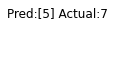

In [22]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(15,4), rows=2, interp=False,titles = None,actual_label=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        if titles is not None and actual_label is not None:
            sp.set_title("Pred:{} Actual:{}".format(titles[i].tolist(),actual_label[i].tolist()), fontsize=12)

        sp.axis('Off')
        plt.imshow((torch.squeeze(ims[i]).tolist()))

plots(data_,titles = pred_,actual_label=target_)	

In [26]:
#################gradcam for misclassified images ################
import config
from gradcam import GradCam
from gradcam import show_cam_on_image
gradcam_img = []
for idx in range(len(data_)): 
    #ip = data_.index_select(0,torch.tensor(idx))
    ip = idx #data_[idx]
    grad_cam = GradCam(model=model, feature_module=model.layer3,target_layer_names=["1"], use_cuda=config.use_cuda)
    mask = grad_cam(ip)
    op_img = show_cam_on_image(ip.squeeze().permute(1,2,0), mask)
    gradcam_img.append(op_img)
#plots(gradcam_img,titles=target_t )
plots(data_,titles = pred_,actual_label=target_)


AttributeError: ignored

In [28]:
import copy
import os
import torch
import numpy as np
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from packaging import version

PYTORCH_VERSION = version.parse(torch.__version__)

try:
    from apex import amp

    IS_AMP_AVAILABLE = True
except ImportError:
    IS_AMP_AVAILABLE = False


class DataLoaderIter(object):
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self._iterator = iter(data_loader)

    @property
    def dataset(self):
        return self.data_loader.dataset

    def inputs_labels_from_batch(self, batch_data):
        if not isinstance(batch_data, list) and not isinstance(batch_data, tuple):
            raise ValueError(
                "Your batch type is not supported: {}. Please inherit from "
                "`TrainDataLoaderIter` or `ValDataLoaderIter` and override the "
                "`inputs_labels_from_batch` method.".format(type(batch_data))
            )

        inputs, labels, *_ = batch_data

        return inputs, labels

    def __iter__(self):
        return self

    def __next__(self):
        batch = next(self._iterator)
        return self.inputs_labels_from_batch(batch)


class TrainDataLoaderIter(DataLoaderIter):
    def __init__(self, data_loader, auto_reset=True):
        super().__init__(data_loader)
        self.auto_reset = auto_reset

    def __next__(self):
        try:
            batch = next(self._iterator)
            inputs, labels = self.inputs_labels_from_batch(batch)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            batch = next(self._iterator)
            inputs, labels = self.inputs_labels_from_batch(batch)

        return inputs, labels


class ValDataLoaderIter(DataLoaderIter):
    """This iterator will reset itself **only** when it is acquired by
    the syntax of normal `iterator`. That is, this iterator just works
    like a `torch.data.DataLoader`. If you want to restart it, you
    should use it like:

        ```
        loader_iter = ValDataLoaderIter(data_loader)
        for batch in loader_iter:
            ...

        # `loader_iter` should run out of values now, you can restart it by:
        # 1. the way we use a `torch.data.DataLoader`
        for batch in loader_iter:        # __iter__ is called implicitly
            ...

        # 2. passing it into `iter()` manually
        loader_iter = iter(loader_iter)  # __iter__ is called by `iter()`
        ```
    """

    def __init__(self, data_loader):
        super().__init__(data_loader)
        self.run_limit = len(self.data_loader)
        self.run_counter = 0

    def __iter__(self):
        if self.run_counter >= self.run_limit:
            self._iterator = iter(self.data_loader)
            self.run_counter = 0
        return self

    def __next__(self):
        self.run_counter += 1
        return super(ValDataLoaderIter, self).__next__()


class LRFinder(object):
    """Learning rate range test.

    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.

    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean, optional): if this flag is set to True, `state_dict` of
            model and optimizer will be cached in memory. Otherwise, they will be saved
            to files under the `cache_dir`.
        cache_dir (string, optional): path for storing temporary files. If no path is
            specified, system-wide temporary directory is used. Notice that this
            parameter will be ignored if `memory_cache` is True.

    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
        >>> lr_finder.plot() # to inspect the loss-learning rate graph
        >>> lr_finder.reset() # to reset the model and optimizer to their initial state

    Reference:
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(
        self,
        model,
        optimizer,
        criterion,
        device=None,
        memory_cache=True,
        cache_dir=None,
    ):
        # Check if the optimizer is already attached to a scheduler
        self.optimizer = optimizer
        self._check_for_scheduler()

        self.model = model
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store("model", self.model.state_dict())
        self.state_cacher.store("optimizer", self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""

        self.model.load_state_dict(self.state_cacher.retrieve("model"))
        self.optimizer.load_state_dict(self.state_cacher.retrieve("optimizer"))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        start_lr=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
        accumulation_steps=1,
        non_blocking_transfer=True,
    ):
        """Performs the learning rate range test.

        Arguments:
            train_loader (`torch.utils.data.DataLoader`
                or child of `TrainDataLoaderIter`, optional):
                the training set data loader.
                If your dataset (data loader) returns a tuple (inputs, labels,*) then
                Pytorch data loader object can be provided. However, if a dataset
                returns different outputs e.g. dicts, then you should inherit
                from `TrainDataLoaderIter` class and redefine `inputs_labels_from_batch`
                method so that it outputs (inputs, labels).
            val_loader (`torch.utils.data.DataLoader`
                or child of `ValDataLoaderIter`, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results.
                Similarly to `train_loader`, if your dataset outputs are not standard
                you should inherit from `ValDataLoaderIter` class and
                redefine method `inputs_labels_from_batch` so that
                it outputs (inputs, labels). Default: None.
            start_lr (float, optional): the starting learning rate for the range test.
                Default: None (uses the learning rate from the optimizer).
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
            accumulation_steps (int, optional): steps for gradient accumulation. If it
                is 1, gradients are not accumulated. Default: 1.
            non_blocking_transfer (bool, optional): when non_blocking_transfer is set,
                tries to convert/move data to the device asynchronously if possible,
                e.g., moving CPU Tensors with pinned memory to CUDA devices. Default: True.

        Example (fastai approach):
            >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)

        Example (Leslie Smith's approach):
            >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> lr_finder.range_test(trainloader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="linear")

        Gradient accumulation is supported; example:
            >>> train_data = ...    # prepared dataset
            >>> desired_bs, real_bs = 32, 4         # batch size
            >>> accumulation_steps = desired_bs // real_bs     # required steps for accumulation
            >>> dataloader = torch.utils.data.DataLoader(train_data, batch_size=real_bs, shuffle=True)
            >>> acc_lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> acc_lr_finder.range_test(dataloader, end_lr=10, num_iter=100, accumulation_steps=accumulation_steps)

        If your DataLoader returns e.g. dict, or other non standard output, intehit from TrainDataLoaderIter,
        redefine method `inputs_labels_from_batch` so that it outputs (inputs, lables) data:
            >>> import torch_lr_finder
            >>> class TrainIter(torch_lr_finder.TrainDataLoaderIter):
            >>>     def inputs_labels_from_batch(self, batch_data):
            >>>         return (batch_data['user_features'], batch_data['user_history']), batch_data['y_labels']
            >>> train_data_iter = TrainIter(train_dl)
            >>> finder = torch_lr_finder.LRFinder(model, optimizer, partial(model._train_loss, need_one_hot=False))
            >>> finder.range_test(train_data_iter, end_lr=10, num_iter=300, diverge_th=10)

        Reference:
        [Training Neural Nets on Larger Batches: Practical Tips for 1-GPU, Multi-GPU & Distributed setups](
        https://medium.com/huggingface/ec88c3e51255)
        [thomwolf/gradient_accumulation](https://gist.github.com/thomwolf/ac7a7da6b1888c2eeac8ac8b9b05d3d3)
        """

        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Check if the optimizer is already attached to a scheduler
        self._check_for_scheduler()

        # Set the starting learning rate
        if start_lr:
            self._set_learning_rate(start_lr)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        if isinstance(train_loader, DataLoader):
            train_iter = TrainDataLoaderIter(train_loader)
        elif isinstance(train_loader, TrainDataLoaderIter):
            train_iter = train_loader
        else:
            raise ValueError(
                "`train_loader` has unsupported type: {}."
                "Expected types are `torch.utils.data.DataLoader`"
                "or child of `TrainDataLoaderIter`.".format(type(train_loader))
            )

        if val_loader:
            if isinstance(val_loader, DataLoader):
                val_iter = ValDataLoaderIter(val_loader)
            elif isinstance(val_loader, ValDataLoaderIter):
                val_iter = val_loader
            else:
                raise ValueError(
                    "`val_loader` has unsupported type: {}."
                    "Expected types are `torch.utils.data.DataLoader`"
                    "or child of `ValDataLoaderIter`.".format(type(val_loader))
                )

        for iteration in tqdm(range(num_iter)):
            # Train on batch and retrieve loss
            loss = self._train_batch(
                train_iter,
                accumulation_steps,
                non_blocking_transfer=non_blocking_transfer,
            )
            if val_loader:
                loss = self._validate(
                    val_iter, non_blocking_transfer=non_blocking_transfer
                )

            # Update the learning rate
            self.history["lr"].append(lr_schedule.get_lr()[0])
            lr_schedule.step()

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _set_learning_rate(self, new_lrs):
        if not isinstance(new_lrs, list):
            new_lrs = [new_lrs] * len(self.optimizer.param_groups)
        if len(new_lrs) != len(self.optimizer.param_groups):
            raise ValueError(
                "Length of `new_lrs` is not equal to the number of parameter groups "
                + "in the given optimizer"
            )

        for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
            param_group["lr"] = new_lr

    def _check_for_scheduler(self):
        for param_group in self.optimizer.param_groups:
            if "initial_lr" in param_group:
                raise RuntimeError("Optimizer already has a scheduler attached to it")

    def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
        self.model.train()
        total_loss = None  # for late initialization

        self.optimizer.zero_grad()
        for i in range(accumulation_steps):
            inputs, labels = next(train_iter)
            inputs, labels = self._move_to_device(
                inputs, labels, non_blocking=non_blocking_transfer
            )

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
            if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
                # For minor performance optimization, see also:
                # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
                delay_unscale = ((i + 1) % accumulation_steps) != 0

                with amp.scale_loss(
                    loss, self.optimizer, delay_unscale=delay_unscale
                ) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

        self.optimizer.step()

        return total_loss.item()

    def _move_to_device(self, inputs, labels, non_blocking=True):
        def move(obj, device, non_blocking=True):
            if hasattr(obj, "to"):
                return obj.to(device, non_blocking=non_blocking)
            elif isinstance(obj, tuple):
                return tuple(move(o, device, non_blocking) for o in obj)
            elif isinstance(obj, list):
                return [move(o, device, non_blocking) for o in obj]
            elif isinstance(obj, dict):
                return {k: move(o, device, non_blocking) for k, o in obj.items()}
            else:
                return obj

        inputs = move(inputs, self.device, non_blocking=non_blocking)
        labels = move(labels, self.device, non_blocking=non_blocking)
        return inputs, labels

    def _validate(self, val_iter, non_blocking_transfer=True):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in val_iter:
                # Move data to the correct device
                inputs, labels = self._move_to_device(
                    inputs, labels, non_blocking=non_blocking_transfer
                )

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * len(labels)

        return running_loss / len(val_iter.dataset)

    def plot(
        self,
        skip_start=10,
        skip_end=5,
        log_lr=True,
        show_lr=None,
        ax=None,
        suggest_lr=True,
    ):
        """Plots the learning rate range test.

        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
            show_lr (float, optional): if set, adds a vertical line to visualize the
                specified learning rate. Default: None.
            ax (matplotlib.axes.Axes, optional): the plot is created in the specified
                matplotlib axes object and the figure is not be shown. If `None`, then
                the figure and axes object are created in this method and the figure is
                shown . Default: None.
            suggest_lr (bool, optional): suggest a learning rate by
                - 'steepest': the point with steepest gradient (minimal gradient)
                you can use that point as a first guess for an LR. Default: True.

        Returns:
            The matplotlib.axes.Axes object that contains the plot,
            and the suggested learning rate (if set suggest_lr=True).
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")
        if show_lr is not None and not isinstance(show_lr, float):
            raise ValueError("show_lr must be float")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Create the figure and axes object if axes was not already given
        fig = None
        if ax is None:
            fig, ax = plt.subplots()

        # Plot loss as a function of the learning rate
        ax.plot(lrs, losses)

        # Plot the suggested LR
        if suggest_lr:
            # 'steepest': the point with steepest gradient (minimal gradient)
            print("LR suggestion: steepest gradient")
            min_grad_idx = None
            try:
                min_grad_idx = (np.gradient(np.array(losses))).argmin()
            except ValueError:
                print(
                    "Failed to compute the gradients, there might not be enough points."
                )
            if min_grad_idx is not None:
                print("Suggested LR: {:.2E}".format(lrs[min_grad_idx]))
                ax.scatter(
                    lrs[min_grad_idx],
                    losses[min_grad_idx],
                    s=75,
                    marker="o",
                    color="red",
                    zorder=3,
                    label="steepest gradient",
                )
                ax.legend()

        if log_lr:
            ax.set_xscale("log")
        ax.set_xlabel("Learning rate")
        ax.set_ylabel("Loss")

        if show_lr is not None:
            ax.axvline(x=show_lr, color="red")

        # Show only if the figure was created internally
        if fig is not None:
            plt.show()

        if suggest_lr and min_grad_idx:
            return ax, lrs[min_grad_idx]
        else:
            return ax


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        if PYTORCH_VERSION < version.parse("1.1.0"):
            curr_iter = self.last_epoch + 1
            r = curr_iter / (self.num_iter - 1)
        else:
            r = self.last_epoch / (self.num_iter - 1)

        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        if PYTORCH_VERSION < version.parse("1.1.0"):
            curr_iter = self.last_epoch + 1
            r = curr_iter / (self.num_iter - 1)
        else:
            r = self.last_epoch / (self.num_iter - 1)

        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile

            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError("Given `cache_dir` is not a valid directory.")

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, "state_{}_{}.pt".format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError("Target {} was not cached.".format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError(
                    "Failed to load state in {}. File doesn't exist anymore.".format(fn)
                )
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""

        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])